In [420]:
import os
import shutil
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.offsetbox as offsetbox
import matplotlib.patches as patches



In [260]:
def load_csv():
    df = pd.read_csv('plant_list.csv')
    df.drop(['Unnamed: 1', 'Unnamed: 15'], axis=1, inplace=True)
    df.columns = [c.lower() for c in df.columns]

    bool_cols = ['dry', 'medium', 'moist', 'sun', 'partial', 'shade', 'deer resistant']
    for col in bool_cols:
        b = pd.Series([False] * df.shape[0])
        b[df[col] == 'Y'] = True
        df[col] = b
    months = {
        mon: i + 3 for i, mon in enumerate(
            ['Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
            )
            }
    for k, v in months.items():
        df = df.replace(k, v)
    timecols = ['mintime', 'maxtime']
    for col in timecols: df[col] = pd.to_numeric(df[col])

    df['cleaned_name'] = df['plant'].apply(lambda x: clean_str(x))
    df.set_index('cleaned_name', inplace=True)
    return df

def clean_str(s):
    return s.replace("'", '').replace(' ', '_').lower()

In [489]:
# Rename screenshots
df = load_csv()
# pics = os.listdir('./orig_pics')
# pics.sort()
# for i, pic in enumerate(pics):
#     shutil.copy(f'./orig_pics/{pic}', f'./cleaned_pics/{clean_str(df.iloc[i]["plant"])}.png')

In [693]:
COLOURS = {
    'White': 'lightyellow',
    'Yellow': 'gold',
    'Pink': 'hotpink',
    'Blue': 'lightskyblue',
    'Lavender': 'plum',
    'Purple': 'darkviolet',
    'Green': 'lawngreen',
    'Red': 'crimson',
    'Orange': 'darkorange',
}

def load_square_image(filename, size):
    img = Image.open(filename)
    img = img.resize((size, size))
    
    c = np.min(np.asarray(img).shape[:2])
    img = img.crop(((size - c) // 2, 0, c + (size - c) // 2, c))
    
    return img

def generate_circle(r, scale_pts=100):
    x = np.linspace(-r, r, int(scale_pts * r)).tolist()
    y = [np.sqrt(r ** 2 - xi ** 2) for xi in x]
    x += x[::-1]
    y += [-yi for yi in y[::-1]]
    return x, y

def plot_circle(x, y, r, ax):
    x_offset, y_offset = generate_circle(r)
    ax.plot([x + xi for xi in x_offset], [y + yi for yi in y_offset], 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plant(plant, x, y, f, ax):
    df = load_csv()
    pts_per_screen_inch = 60
    screen_inches_per_image_foot = np.max(f.get_size_inches()) / np.max([ax.get_xlim()[1], ax.get_ylim()[1]])
    
    pts_per_image_foot = 12 * 2.54 * 5
    plant_footprint = df.loc[plant]['spacing']
    imagebox = offsetbox.OffsetImage(
        load_square_image(f'cleaned_pics/{plant}.png', int(plant_footprint * pts_per_image_foot)),
        zoom = pts_per_screen_inch * screen_inches_per_image_foot / pts_per_image_foot * 0.9
    ) 
    ax.add_artist(offsetbox.AnnotationBbox(
        imagebox, (x, y), frameon = False
    ))
    plot_circle(x, y, plant_footprint / 2, ax)
    
def plot_garden_sideview(plant_locs_df, width, figsize_x):
    df = load_csv()
    d = plant_locs_df.sort_values(by=['loc_y'], ascending=False)
    height = df.loc[d['plant']]['maxheight'].max()
    f, ax = plt.subplots(figsize=(figsize_x, figsize_x * height/width))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    for i, row in d.iterrows():
        plant_info = df.loc[row['plant']]
        ax.add_patch(patches.Rectangle(
            (row['loc_x'] - plant_info['spacing'] / 2, 0), 
            plant_info['spacing'], np.mean([plant_info['maxheight'], plant_info['minheight']]),
            facecolor=COLOURS[plant_info['colour']], edgecolor=[0.3] * 3, alpha=0.7,
            ))

def plot_garden_base(width, height, figsize):
    f, ax = plt.subplots(1, 1, figsize=(figsize * width/height, figsize))
    ax.set(xlim=[0, width], ylim=[0, height], aspect='equal')
    plt.axis('off')
    f.tight_layout()
    return f, ax

def plot_garden(plant_locs_df, figsize=10, width=20, height=20, plot_sideview=True):
    f, ax = plot_garden_base(width, height, figsize)
    for i, row in plant_locs_df.iterrows():
        plot_plant(row['plant'], row['loc_x'], row['loc_y'], f, ax)
    if plot_sideview:
        plot_garden_sideview(plant_locs_df, width, f.get_size_inches()[1])

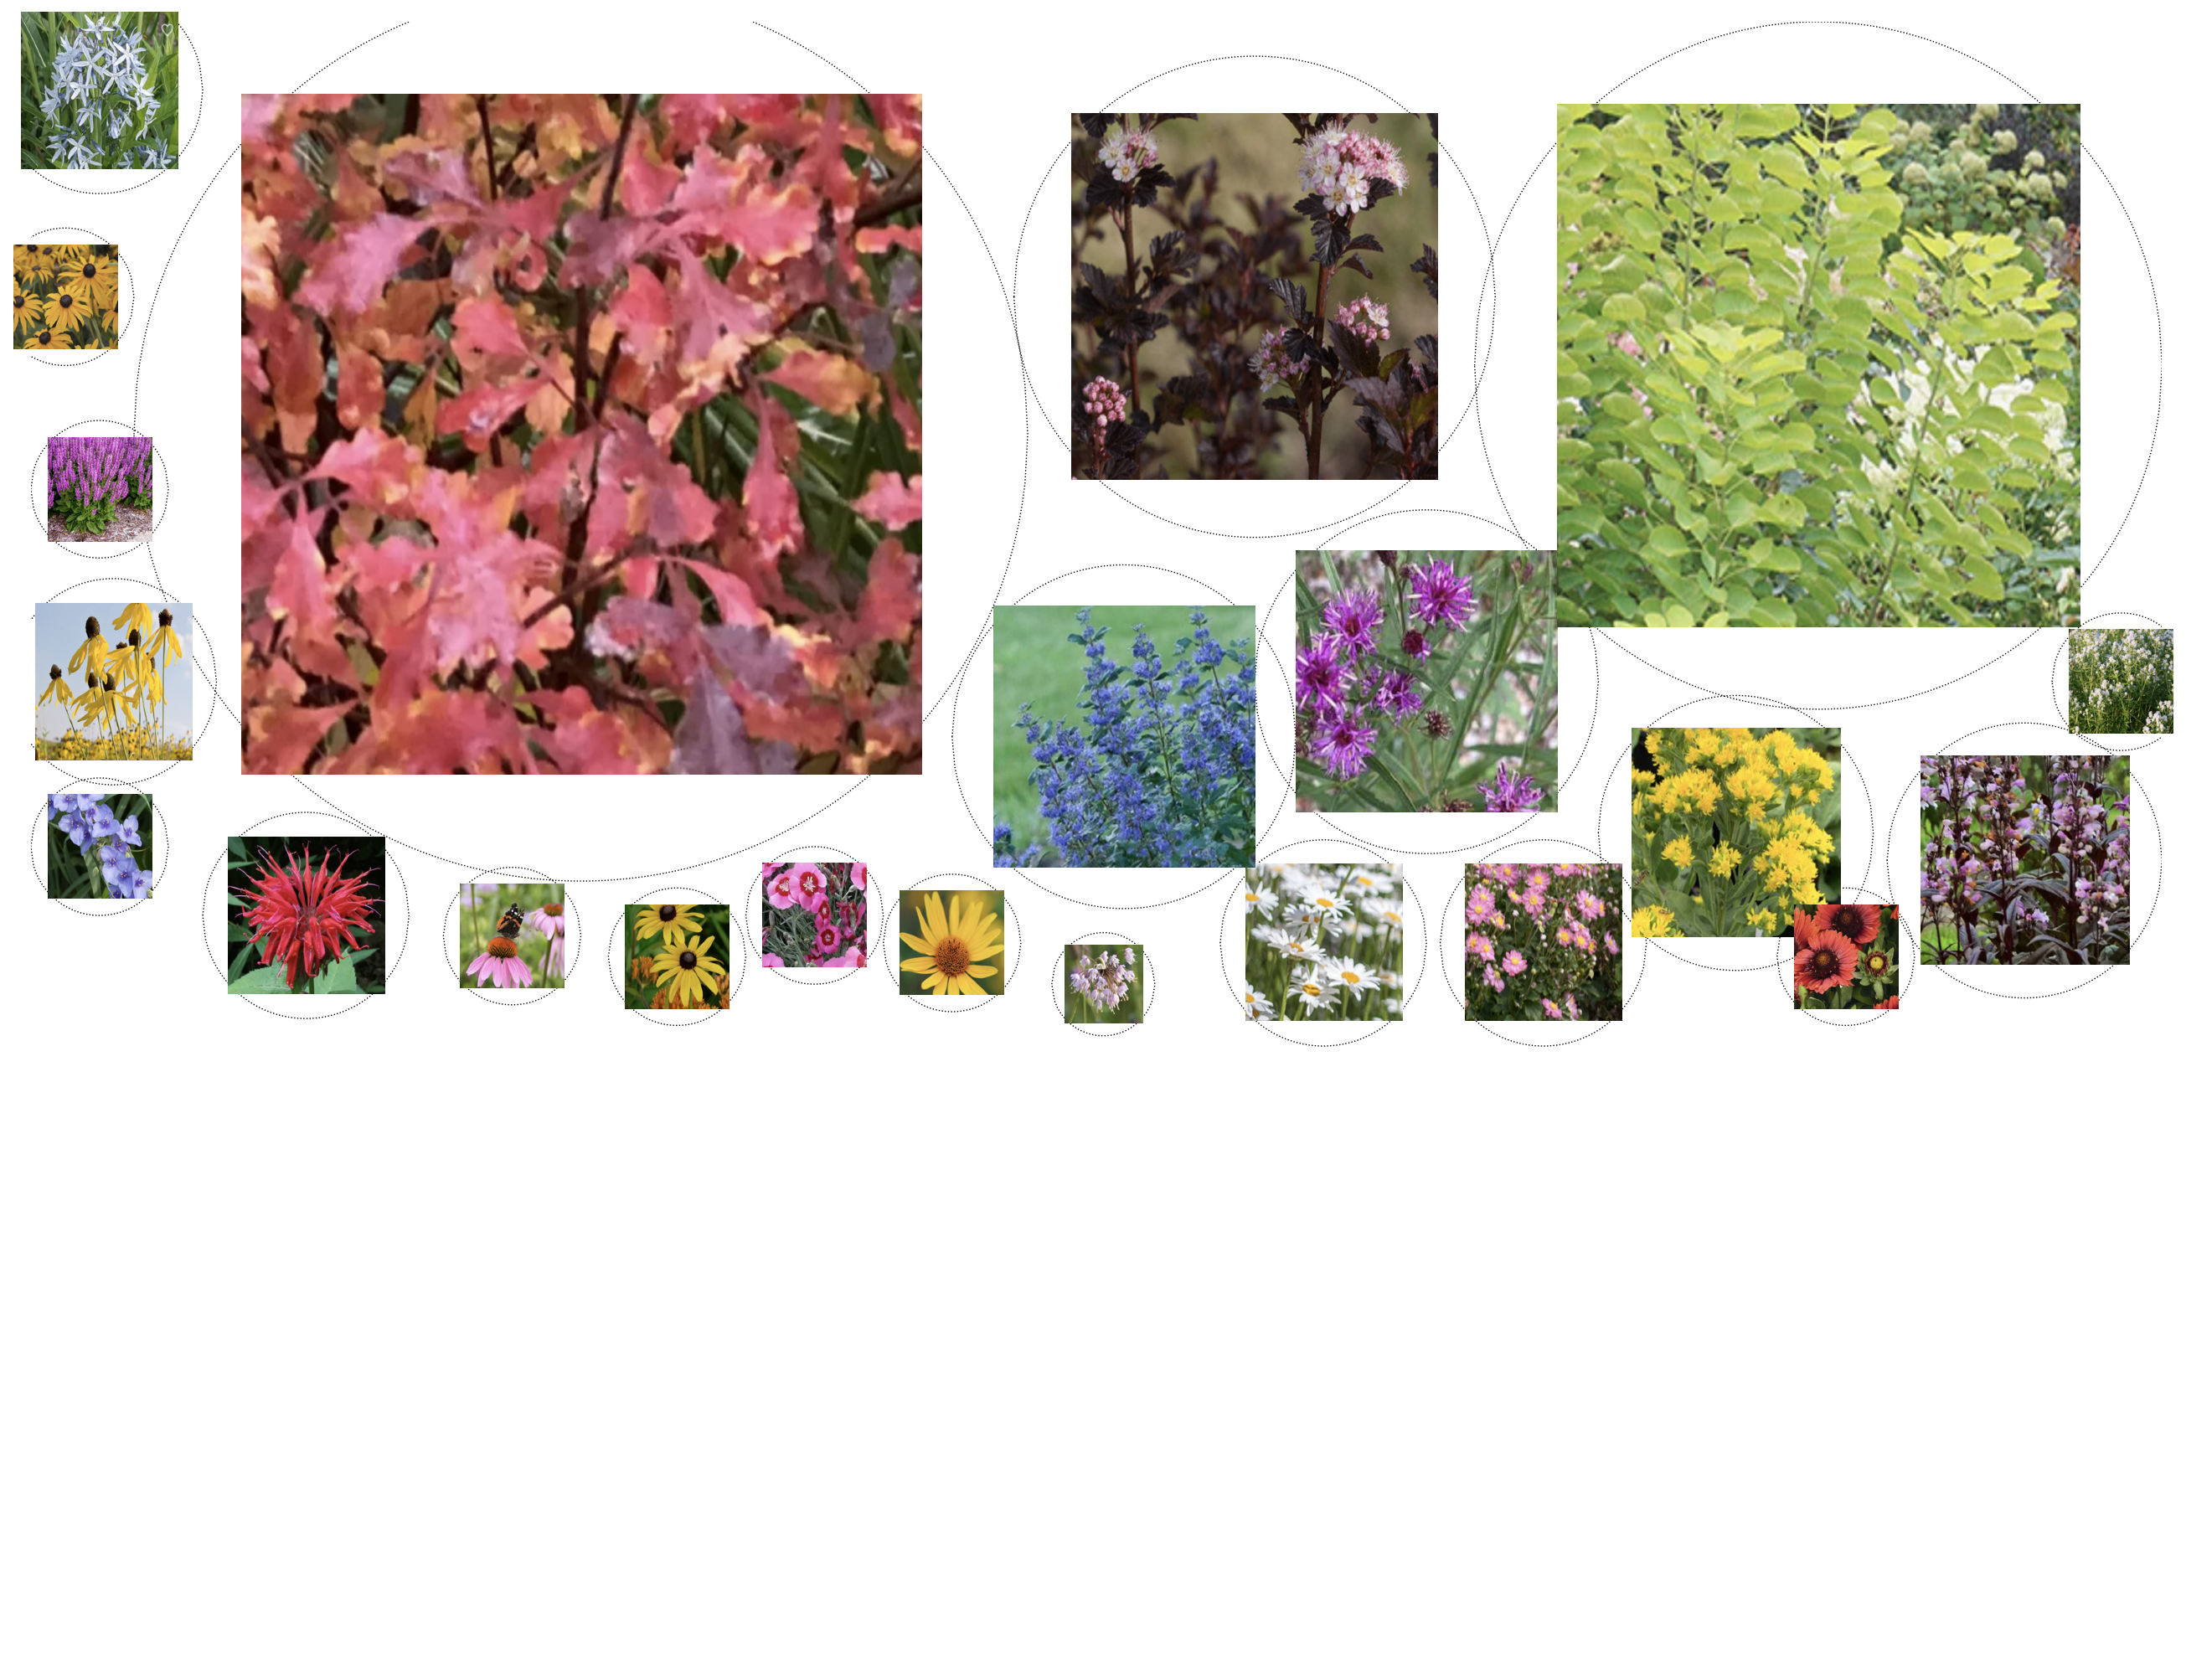

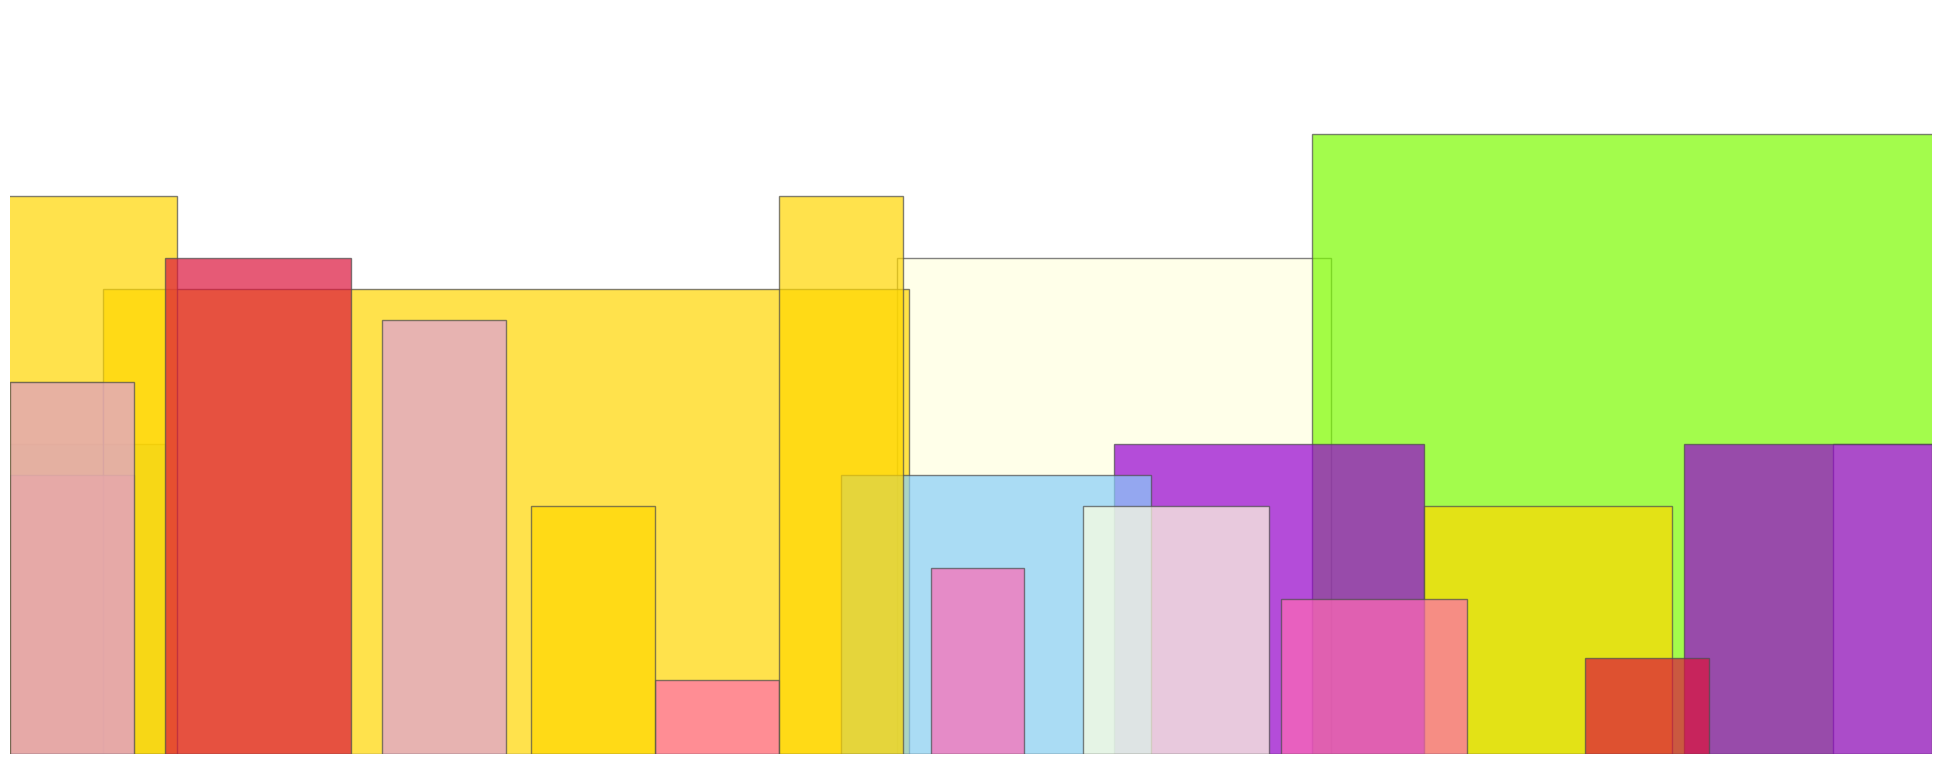

In [487]:
plant_locs_planted = (
    ('pink_onion', 7.8, 8),
    ('dianthus', 5.7, 8.5),
    ('beardtongue', 14.5, 8.9),
    ('black_eyed_susan', 4.7, 8.2),
    ('anemone', 11, 8.3),
    ('orange_coneflower', 0.25, 13),
    ('pink_sage', 0.5, 11.6),
    ('ox_eye_sunflower', 6.7, 8.3),
    ('common_bluestar', 0.5, 14.5),
    ('golden_rockets_goldenrod', 12.4, 9.1),
    ('shasta_daisy', 9.4, 8.3),
    ('mountain_mint', 15.2, 10.2),
    ('red_beebalm', 2, 8.5),
    ('ohio_spiderwort', 0.5, 9),
    ('purple_coneflower', 3.5, 8.35),
    ('yellow_coneflower', 0.6, 10.2),
    ('bluebeard', 7.95, 9.8),
    ('dwarf_ninebark', 8.9, 13),
    ('blanket_flower', 13.2, 8.2),
    ('lettermans_ironweed', 10.15, 10.2),
    ('fragrant_sumac', 4, 12),
    ('smokebush', 13, 12.5),
)
a, b, c, = zip(*plant_locs_planted)
plant_locs_df = pd.DataFrame({
    'plant': a, 'loc_x': b, 'loc_y': [ci - 3 for ci in c]
})
plot_garden(plant_locs_df, height=12, width=15.5, figsize=20)



In [555]:
def list_inds(list_in, inds):
    return [list_in[i] for i in inds]

def recursive_fill_line(item_widths, item_ratios, overall_width):
    if len(item_widths) == 1:
        return [overall_width // item_widths[0]]

    res = [0] * len(item_widths)
    item_ratios = [ir / sum(item_ratios) for ir in item_ratios] # Normalise so item_ratios adds up to 1

    # Find the biggest (least flexible) item
    inds = np.argsort(item_widths).tolist()
    i = inds.pop()
    buffer = 0.1
    res[i] = int(np.round((item_ratios[i] * overall_width) / item_widths[i] - buffer))

    res_rec = recursive_fill_line(
        list_inds(item_widths, inds), list_inds(item_ratios, inds), overall_width - res[i] * item_widths[i]
        )
    for i, ind in enumerate(inds): 
        res[ind] = int(res_rec[i])
    return res


In [557]:
def disp_results(n, item_widths, item_ratios, overall_width):
      print('; '.join([f'{ni} items: ({ni*iw}\', {ni*iw/overall_width:.0%})' for ni, iw in zip(n, item_widths)]))
      print(f'Total: {sum([ni * iw for ni, iw in zip(n, item_widths)])}\'; Desired: {overall_width}\' ('
            + ', '.join([f'{ir/ sum(item_ratios):.0%}' for ir in item_ratios]) + ')')


item_widths = [5, 4, 2, 10, 7]; item_ratios = [55, 40, 80, 70, 10]; overall_width=300;
n = recursive_fill_line(item_widths, item_ratios, overall_width)

print('Fancy way:')
disp_results(n, item_widths, item_ratios, overall_width)

print('\nStraightforward way: ')
n = [int(ir * overall_width / iw / sum(item_ratios)) for iw, ir in zip(item_widths, item_ratios)]
disp_results(n, item_widths, item_ratios, overall_width)


Fancy way:
13 items: (65', 22%); 12 items: (48', 16%); 46 items: (92', 31%); 8 items: (80', 27%); 2 items: (14', 5%)
Total: 299'; Desired: 300' (22%, 16%, 31%, 27%, 4%)

Straightforward way: 
12 items: (60', 20%); 11 items: (44', 15%); 47 items: (94', 31%); 8 items: (80', 27%); 1 items: (7', 2%)
Total: 285'; Desired: 300' (22%, 16%, 31%, 27%, 4%)


In [718]:
LENGTH = 120; WIDTH = 100
SCALE = 12 * 2.54

def create_grid(length, width, scale=1):
    return np.zeros((length * scale, width * scale))

def random_point(grid):
    return (random.randint(0, grid.shape[0]), random.randint(0, grid.shape[1]))

def plot_star_and_dots(coords, x, y,):
    f, ax = plt.subplots(figsize=(5, 5))
    ax.plot(coords[0], coords[1], 'r*')
    ax.plot(x, y, 'k.')
    ax.set(aspect='equal')
    plt.axis('off')
    f.tight_layout()

def circle_points_around_coord(coords, distance, scale=1, ifplot=False):
    x, y = generate_circle(int(np.ceil(distance * scale)))
    pts = pd.DataFrame({'x': [round(coords[0] + xi) for xi in x], 'y': [round(coords[1] + yi) for yi in y]})
    if ifplot: plot_star_and_dots(coords, pts['x'], pts['y'])
    return pts

def drop_points_outside_grid(df, grid):
    return df.drop(
        (df['x'] < 0) | (df['y'] < 0) | (grid.shape[0] <= df['x']) | (grid.shape[1] <= df['y'])
    ).reset_index(drop=True)

def push_points_within_grid(df, grid):
    res = df.copy()
    res.loc[res['x'] < 0, 'x'] = 0
    res.loc[res['y'] < 0, 'y'] = 0
    res.loc[grid.shape[0] <= res['x'], 'x'] = grid.shape[0] - 1
    res.loc[grid.shape[1] <= res['y'], 'y'] = grid.shape[1] - 1
    return res.drop_duplicates().reset_index(drop=True)

def constrained_distance_random_point(coords, distance, grid, scale=1):
    pts = circle_points_around_coord(coords, distance, scale)
    pts = drop_points_outside_grid(pts, grid)
    for i, row in pts.sample(pts.shape[0]).iterrows():
        if grid[row['x'], row['y']] == 0:
            return (True, row['x'], row['y'])
    return (False, -1, -1)


def hits_grid_edge(coords, grid, radius):
    return (
        (coords[0] < radius) or (coords[1] < radius)
        or (grid.shape[0] - coords[0] < radius) or (grid.shape[1] - coords[1] < radius)
    )

def recursive_search(coords, grid, radius_small, radius_large):
    epsilon = 2
    if radius_large - radius_small < epsilon:
        return radius_large

    # If there are hits within the radius_small circle, try halving the size
    if sum_values_within_circle(coords, radius_small, grid) > 0:
        # Minimum bound is always 0
        return recursive_search(coords, grid, radius_small // 2, radius_small)
    
    # If there are no hits within the radius_large circle, try doubling the size
    if sum_values_within_circle(coords, radius_large, grid) > 0:
        # Constrain radius_large with the max grid size
        if hits_grid_edge(coords, grid, radius_large):
            return max([coords[0], coords[1], grid.shape[0] - coords[0], grid.shape[1] - coords[1]])
        return recursive_search(coords, grid, radius_large, radius_large * 2)

    # Otherwise, there are hits inside the radius_large but not the radius_small
    radius_halfway = int(np.mean([radius_small, radius_large]))
    # If there are hits within the halfway circle, search between there and radius_small
    if sum_values_within_circle(coords, radius_halfway, grid) > 0:
        return recursive_search(coords, grid, radius_small, radius_halfway)
    return recursive_search(coords, grid, radius_halfway, radius_large)



def find_max_free_circle_around_point(coords, grid):
    # The minimum constraint: the circle bumps into the edge of the grid
    max_poss_radius = min([coords[0], coords[1], grid.shape[0] - coords[0], grid.shape[1] - coords[1]])
    if sum_values_within_circle(coords, max_poss_radius, grid) == 0:
        return max_poss_radius

    # Binary search
    if sum_values_within_circle(coords, max_poss_radius // 2, grid) == 0:
        return
    



grid = create_grid(LENGTH, WIDTH)
random_point(grid)



(46, 69)

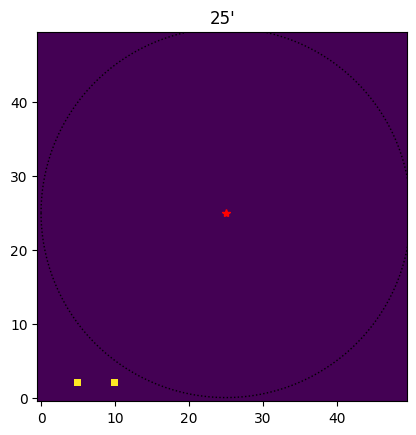

In [729]:
def recursive_search(coords, grid, radius_small, radius_large):
    epsilon = 1
    if radius_large - radius_small <= epsilon:
        if radius_small == 1:
            return 0
        if hits_grid_edge(coords, grid, radius_large):
            return min([coords[0], coords[1], grid.shape[0] - coords[0], grid.shape[1] - coords[1]])
        return radius_small

    # If there are hits within the radius_small circle, try halving the size
    if 0 < sum_values_within_circle(coords, radius_small, grid):
        # Constrain radius_small at 0
        if radius_small == 1:
            return 0
        return recursive_search(coords, grid, radius_small // 2, radius_small)
    
    # If there are no hits within the radius_large circle, try doubling the size
    if sum_values_within_circle(coords, radius_large, grid) == 0:
        # Constrain radius_large with the max grid size
        if hits_grid_edge(coords, grid, radius_large):
            return min([coords[0], coords[1], grid.shape[0] - coords[0], grid.shape[1] - coords[1]])
        return recursive_search(coords, grid, radius_large, radius_large * 2)

    # Otherwise, there are hits inside the radius_large but not the radius_small
    radius_halfway = int(np.mean([radius_small, radius_large]))
    # If there are hits within the halfway circle, search between there and radius_small
    if 0 < sum_values_within_circle(coords, radius_halfway, grid):
        return recursive_search(coords, grid, radius_small, radius_halfway)
    return recursive_search(coords, grid, radius_halfway, radius_large)


def sum_values_within_circle(coords, distance, grid):
    pts = push_points_within_grid(circle_points_around_coord(coords, distance), grid)
    res = 0
    for x in pts['x'].unique():
        if x < 0 or grid.shape[0] <= x: continue
        min_y = max([0, pts[pts['x'] == x]['y'].min()])
        max_y = min([grid.shape[1], pts[pts['x'] == x]['y'].max()])
        res += sum(grid[x, min_y:max_y])
    return res

grid = np.zeros((50, 50))
grid[2, 10] = 1
grid[2, 5] = 1
coords = [25, 25]
res = recursive_search(coords, grid, 2, max(grid.shape))
f, ax = plt.subplots()
ax.imshow(grid)
ax.plot(coords[0], coords[1], 'r*')
plot_circle(coords[0], coords[1], res, ax)
ax.set(xlim=[-.5, grid.shape[0]-0.5], ylim=[-0.5, grid.shape[1]-0.5], title=f'{res}\'');

In [731]:
grid[grid == 1]

array([1., 1.])

In [ ]:
def find_max_free_circle_around_point(coords, grid):
    if sum(grid) == 0:
        return min([coords[0], coords[1], grid.shape[0] - coords[0], grid.shape[1] - coords[1]])
    res = max(grid.shape)
    

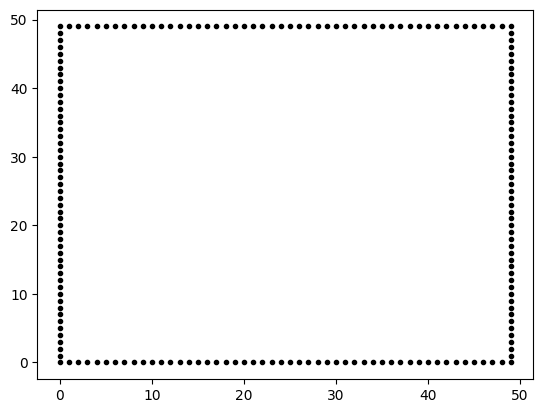

In [724]:
pts = circle_points_around_coord(coords, 50)
pts = push_points_within_grid(pts, grid)
# pts.loc[pts['x'] < 0, 'x'] = 0
# pts.loc[pts['y'] < 0, 'y'] = 0
# pts.loc[grid.shape[0] <= pts['x'], 'x'] = grid.shape[0] - 1
# pts.loc[grid.shape[1] <= pts['y'], 'y'] = grid.shape[1] - 1
# grid.shape[0]
# pts
plt.plot(pts['x'], pts['y'], 'k.')
# res = 0
# for x in [10]:#pts['x'].unique():
#     if x < 0 or grid.shape[0] <= x: continue
#     min_y = max([0, pts[pts['x'] == x]['y'].min()])
#     max_y = min([grid.shape[1], pts[pts['x'] == x]['y'].max()])
#     print(min_y, max_y)
#     res += sum(grid[x, min_y:max_y])
# res

In [655]:
pts = circle_points_around_coord(coords, 30)

for x in pts.sort_values(by='x', ascending=True)['x'].unique():
    print(x, sum(grid[x, pts[pts['x'] == x]['y'].min():pts[pts['x'] == x]['y'].max() + 1]))


24 3.0
25 3.0
26 3.0


In [636]:
pts = constrained_distance_random_point([5, 10], 15, grid)
pts.sample(1).values.flatten().tolist()

[14, 22]

In [592]:
pts = pd.DataFrame({'x': [1, 2, 3, -1], 'y': [0, -10, 4, 2]})
pts.drop(pts[pts['x'] < 0].index).drop(pts[pts['y'] < 0].index)

x  y
0  1  0
2  3  4

[None]

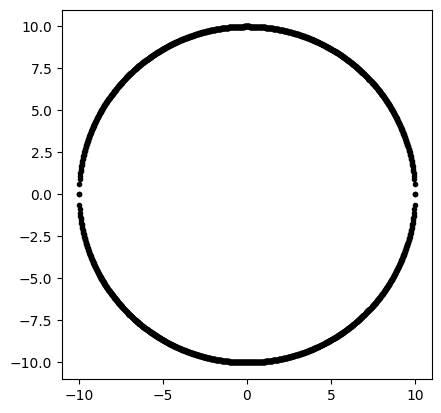

In [587]:
x, y = generate_circle(10, 100)
f, ax = plt.subplots()
ax.plot(x, y, 'k.')
ax.set(aspect='equal')

In [490]:
sum([1, 2, 3])

6

In [484]:
def get_plant_stats():
    df = load_csv()
    

plant             Yellow Coneflower
dry                            True
medium                         True
moist                          True
sun                            True
partial                       False
shade                         False
minheight                       3.0
maxheight                       6.0
colour                       Yellow
mintime                           7
maxtime                           9
spacing                         1.5
deer resistant                 True
Name: yellow_coneflower, dtype: object

In [482]:
df[df['plant'].str.lower().str.contains('cone')]['plant'].sort_index().values

array(['Orange Coneflower', 'Pale Purple Coneflower', 'Purple Coneflower',
       'Yellow Coneflower'], dtype=object)

In [ ]:
a, b, c = zip(*zip(
    ['yellow_coneflower'] * 10, [5] * 10, [1] * 10
))
plant_locs_planned = pd.DataFrame({
    'plant': a, 'loc_x': b, 'loc_y': c
})
plot_garden(plant_locs_planned, height=40-12, width=15.5, figsize=10)

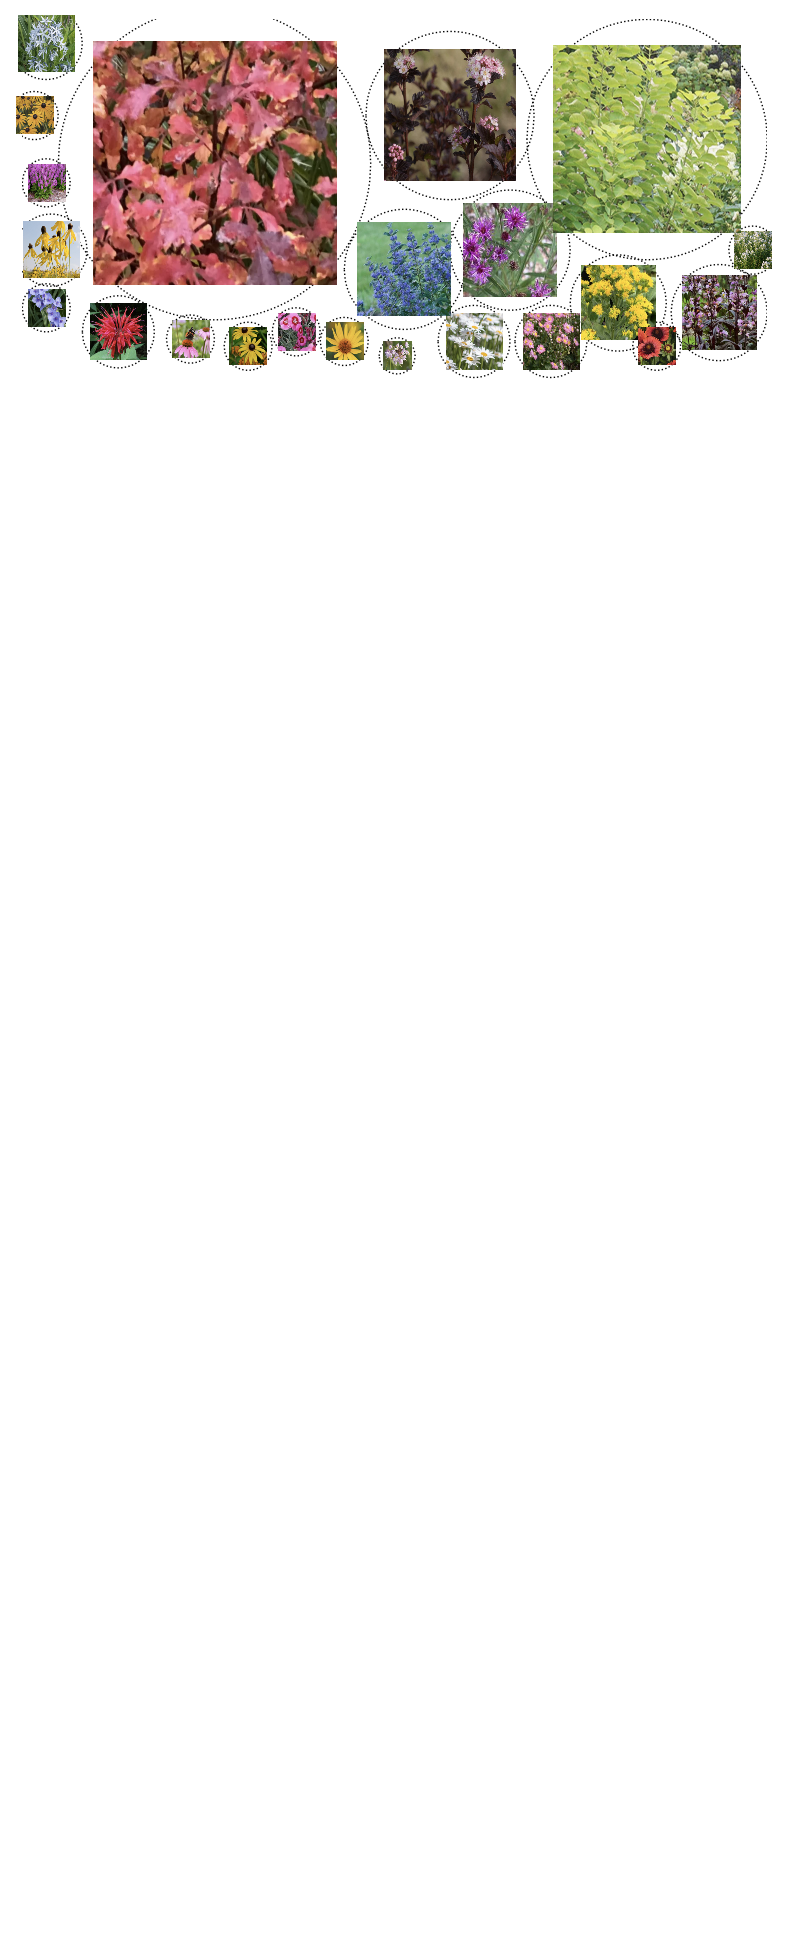

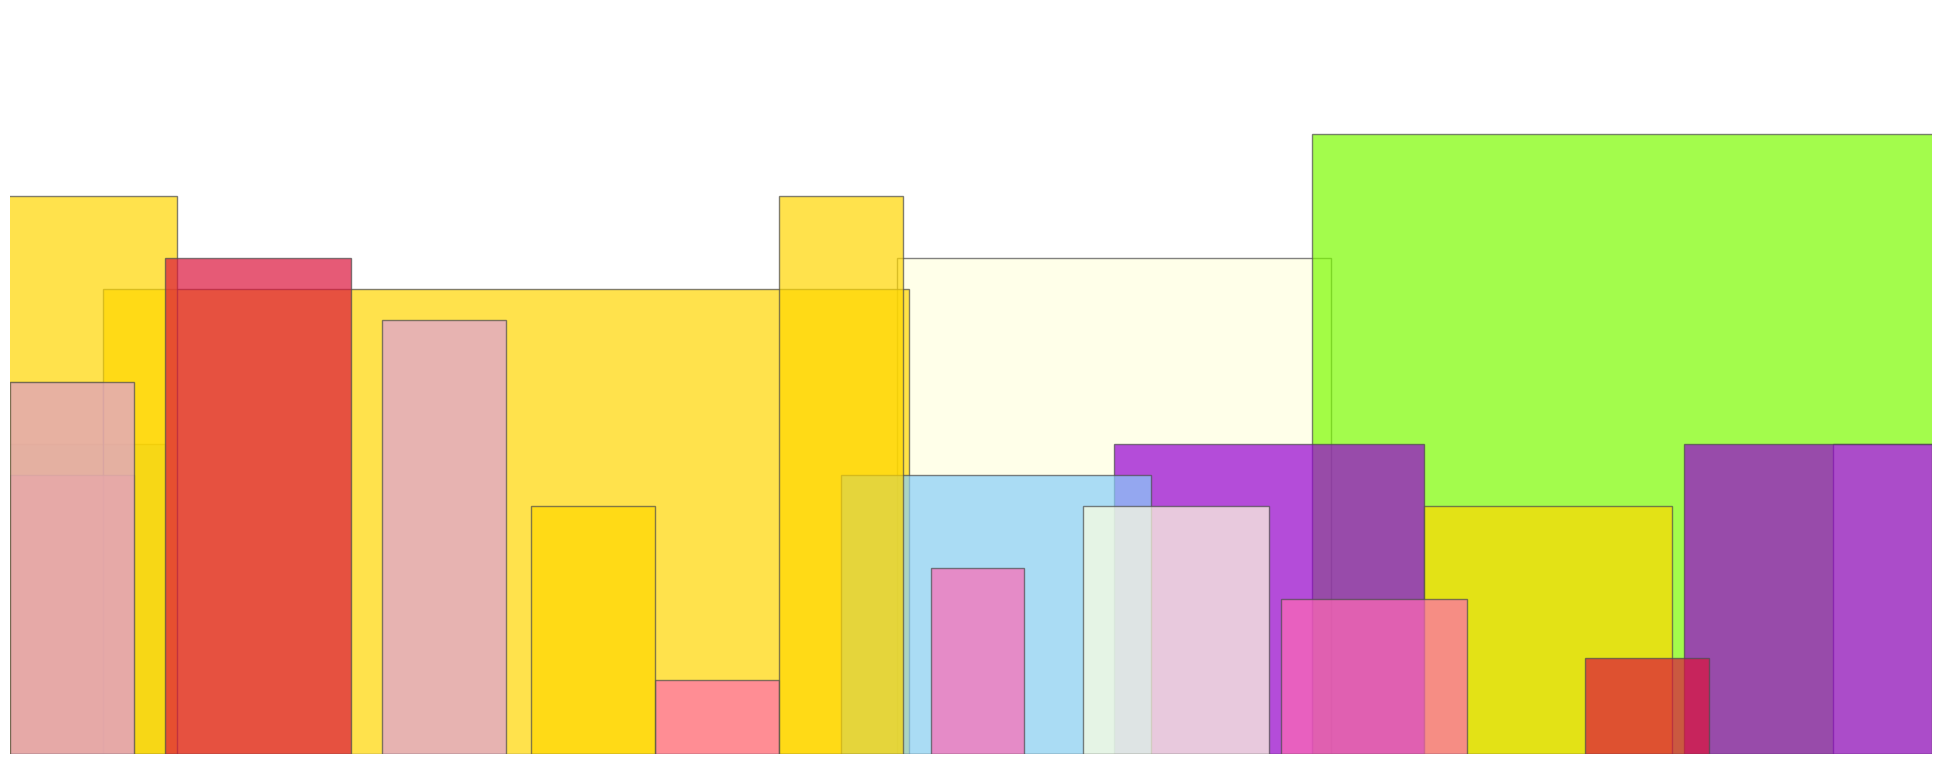

6.0

In [426]:
df.colour.value_counts()

White       18
Yellow      17
Pink        10
Blue         8
Lavender     7
Purple       6
Green        5
Red          3
Orange       1
Name: colour, dtype: int64

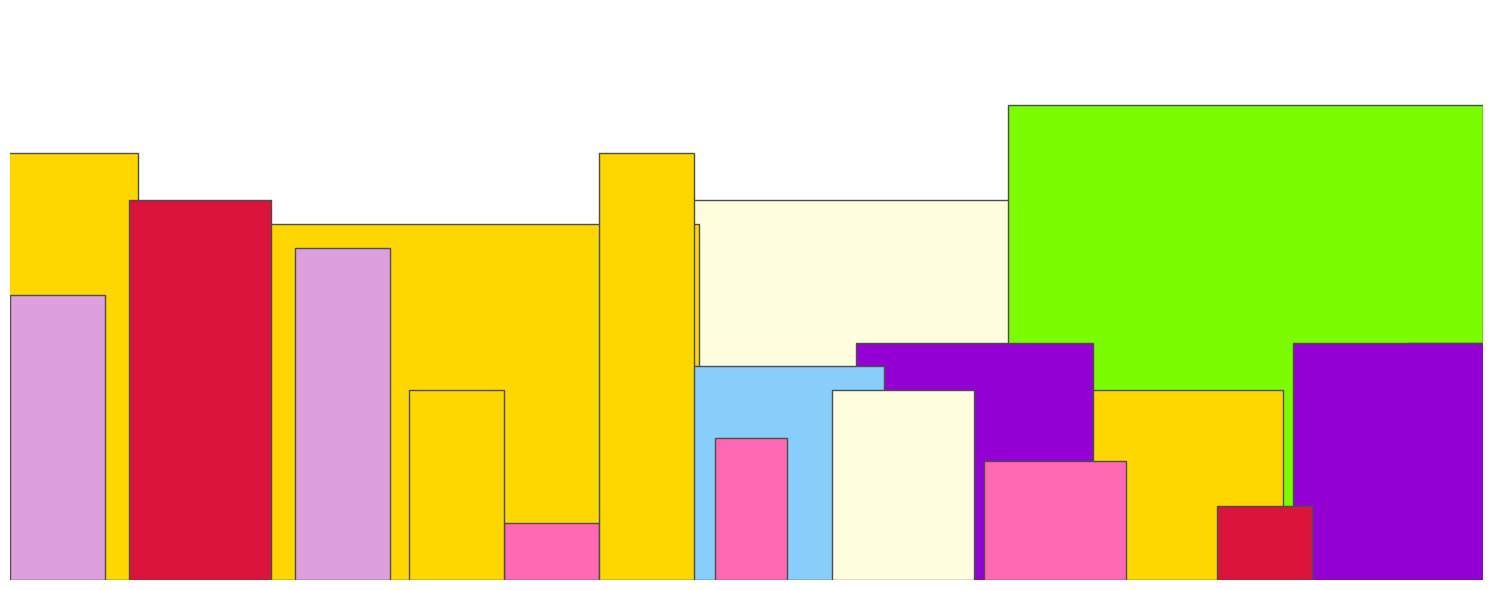

In [274]:
df = load_csv()
df.head()

plant    dry  medium  moist   sun  partial  \
cleaned_name                                                              
pink_onion              Pink Onion  False    True   True  True    False   
common_bluestar    Common Bluestar  False    True   True  True     True   
big_bluestem          Big Bluestem   True    True   True  True    False   
black_chokeberry  Black Chokeberry   True    True   True  True     True   
red_milkweed          Red Milkweed  False   False   True  True    False   

                  shade  minheight  maxheight colour  mintime  maxtime  \
cleaned_name                                                             
pink_onion        False        1.0        2.0   Pink        7        8   
common_bluestar   False        2.0        3.0   Blue        5        6   
big_bluestem      False        5.0        8.0    Red        8       10   
black_chokeberry  False        4.0        6.0  White        5        5   
red_milkweed      False        3.0        5.0   Pink        6        7   

                  spacing  deer resistant  
cleaned_name                               
pink_onion           0.75            True  
common_bluestar      1.50            True  
big_bluestem         2.00            True  
black_chokeberry     4.50           False  
red_milkweed         1.25           False

5 - Bergamot, 
6 - Butterfly Weed for Clay
6 - Nodding Pink Onion
5 - Ox Eye Sunflower
5 - Purple Prairie Clover
5 - Wild Senna	

6 - Black Eyed Susan
5 - Big Bluestem
6 - New England Aster
5 - Purple Coneflower
5 - Stiff Goldenrod
5 - Switchgrass